In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import os

from dotenv import load_dotenv
import itertools

In [3]:
# env variables
load_dotenv()
# edit the environment file to your datafile
data_path = os.environ.get("data_path")

In [4]:
type(data_path)

str

In [5]:
os.chdir(data_path)
df_tx = pd.read_csv('15minute_data_austin.csv')
#df_ca = pd.read_csv('15minute_data_california.csv') not using for our project
df_ny = pd.read_csv('15minute_data_newyork.csv')

In [6]:
def clean_up_dataset(dataframe):
    sorted_df = dataframe.sort_values(by= ['local_15min'])
    all_sorted_time = sorted_df['local_15min'].unique()
    time_ids = {}
    unique_ids = {}
    counter = 0
    dataframe = dataframe.fillna(0)
    
    # Assign a unique numerical id to each timestamp
    for i in all_sorted_time:
        time_ids.update({i: counter})
        unique_ids.update({counter: i})
        counter += 1

    
    def get_front_back(df, date):
        if time_ids[date] - 1 > 0:
            back = unique_ids[time_ids[date] - 1]
        else:
            back = date
        if time_ids[date] + 1 < len(unique_ids):
            front = unique_ids[time_ids[date] + 1]
        else:
            front = date
        return (df[df['local_15min'] == front]['grid'], df[df['local_15min'] == back]['grid'])
    
    def missing_times(lst1, lst2):
        # takes unique list and finds the difference in other list
        return list(set(lst1).difference(lst2))
    
    # Append missing data values
    time_labels = []
    grid_interpret = []
    data_labels =[]
    num_uid = 0
    for k in dataframe['dataid'].unique():
        num_uid += 1
        cur_mis = missing_times(all_sorted_time, dataframe[dataframe['dataid'] == k]['local_15min'].unique())
        print(f"Household ID {k} is missing {len(cur_mis)} timestamps.")
        for j in cur_mis:
            time_labels += [j]
            grid_interpret += [np.nan]
            data_labels += [k]
            
    sorted_id = dataframe.append(pd.DataFrame({'local_15min': time_labels, 'grid': grid_interpret, 'dataid': data_labels}),
                    ignore_index = True)
    
    # Resort by data labels
    sorted_id = sorted_id.sort_values(by= ['dataid'])
    sorted_id.reset_index(drop=True,inplace=True)

    # Apply interpolation by indexing into separate UIDs
    df_list = []
    for uid in sorted_id['dataid'].unique():
        grid_pts = sorted_id.loc[sorted_id['dataid']==uid,:].copy()
        grid_pts = grid_pts.sort_values(by=['local_15min'],ignore_index=True)
        interp = grid_pts.interpolate(method='polynomial',order = 5)
        df_list.append(interp)
      
    sorted_id = pd.concat(df_list,ignore_index=True)
    return sorted_id

In [7]:
sorted_cleaned_tx = clean_up_dataset(df_tx)
# sorted_cleaned_ca = clean_up_dataset(df_ca)
sorted_cleaned_ny = clean_up_dataset(df_ny)

Household ID 661 is missing 4 timestamps.
Household ID 1642 is missing 388 timestamps.
Household ID 2335 is missing 568 timestamps.
Household ID 2361 is missing 52 timestamps.
Household ID 2818 is missing 56 timestamps.
Household ID 3039 is missing 0 timestamps.
Household ID 3456 is missing 104 timestamps.
Household ID 3538 is missing 0 timestamps.
Household ID 4031 is missing 0 timestamps.
Household ID 4373 is missing 504 timestamps.
Household ID 4767 is missing 77 timestamps.
Household ID 5746 is missing 300 timestamps.
Household ID 6139 is missing 0 timestamps.
Household ID 7536 is missing 52 timestamps.
Household ID 7719 is missing 156 timestamps.
Household ID 7800 is missing 16 timestamps.
Household ID 7901 is missing 144 timestamps.
Household ID 7951 is missing 0 timestamps.
Household ID 8156 is missing 52 timestamps.
Household ID 8386 is missing 0 timestamps.
Household ID 8565 is missing 0 timestamps.
Household ID 9019 is missing 108 timestamps.
Household ID 9160 is missing 32 t

In [8]:
def get_date(date):
    if type(date) == str:
        dtobj = dt.datetime.strptime(date, '%Y-%m-%d %H:%M:%S-%f')
        return dtobj.year * 10000 + dtobj.month * 100 + dtobj.day
    return date.year * 10000 + date.month * 100 + date.day

def all_days(df):
    days = []
    i = 96
    while i < len(df):
        days.append(get_date(df.iloc[i-1]['local_15min']))
    return days

In [9]:
def multi_index_dataframe(df):
    df_days_all = df[df['dataid'] == df['dataid'][0]]['local_15min']
    df_days = []
    i = 96
    while i < len(df_days_all):
        df_days += [get_date(df_days_all[i-1])]
        i += 96
    iterables = [df['dataid'].unique(), df_days]
    multi_index = pd.MultiIndex.from_product(iterables, names=["dataid", "date"])    
    vals = []
    for houseid in df['dataid'].unique():
        temp = df[df['dataid'] == houseid]
        temp_dict = {}
        i = 96
        while i < len(temp):
            vals_temp = list(temp[i - 96:i]['grid'])
            vals += [vals_temp]
            i += 96
    df_final = pd.DataFrame(vals, index = multi_index, columns = np.arange(96))
    return df_final

In [10]:
multi_tx = multi_index_dataframe(sorted_cleaned_tx)

In [11]:
multi_ny = multi_index_dataframe(sorted_cleaned_ny)

In [12]:
multi_ny.head()

0      1      2      3      4      5      6      7   \
dataid date                                                               
27     20190501  0.997  0.750  0.608  1.057  0.518  1.163  0.591  1.155   
       20190502  0.300  0.275  0.296  0.836  0.248  0.269  0.753  0.374   
       20190503  0.352  0.355  0.265  0.219  0.304  0.342  0.336  0.301   
       20190504  0.408  0.311  0.359  0.364  0.266  0.209  0.303  0.413   
       20190505  0.544  0.503  0.781  0.368  0.901  0.369  0.658  0.600   

                    8      9   ...     86     87     88     89     90     91  \
dataid date                    ...                                             
27     20190501  0.840  0.697  ...  0.557  1.052  0.561  0.596  0.284  0.394   
       20190502  0.249  0.374  ...  0.741  0.830  0.749  0.703  0.224  0.233   
       20190503  0.304  0.304  ...  0.666  0.477  0.331  0.331  0.316  0.316   
       20190504  0.290  0.209  ...  1.449  0.782  2.082  1.291  1.140  0.811   
       20190505  0.440  0.808  ...  1.196  0.677  0.859  0.458  0.599  0.507   

                    92     93     94     95  
dataid date                                  
27     20190501  0.356  0.219  0.605  0.304  
       20190502  0.355  0.409  0.294  0.260  
       20190503  0.231  0.277  0.361  0.376  
       20190504  0.592  1.059  0.969  0.665  
       20190505  0.564  0.669  0.540  0.631  

[5 rows x 96 columns]

In [13]:
multi_ny.xs(20190501,level = 1).index

Int64Index([  27,  142,  387,  558,  914,  950, 1222, 1240, 1417, 2096, 2318,
            2358, 3000, 3488, 3517, 3700, 3996, 4283, 4550, 5058, 5587, 5679,
            5982, 5997, 9053],
           dtype='int64', name='dataid')

In [14]:
multi_ny.loc[27,:].index - multi_ny.loc[27,:].index[0]

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            520, 521, 522, 523, 524, 525, 526, 527, 528, 529],
           dtype='int64', name='date', length=183)

In [23]:
def plot_from_multi(multi_df: 'DataFrame', day: int): # day is the day stamp to plot
    day_str = str(day)
    plt.figure(figsize = (25, 8),dpi=300)
    plt.rcParams.update({'font.size': 22})
    ax = plt.gca()
    household_use = multi_df.xs(day,level=1) # index on second level only
    
    # Create 15 minute intervals
    def pad_hours(string):
        if len(string)<2:
            string = '0'+string
        return string
    
    hours = np.arange(25)
    hours = [pad_hours(str(hour)) for hour in hours]
    #minutes = ['00','15','30','45']
    #day_intervals = sorted(list(itertools.product(hours,minutes)))
    
    # Plot energy use data
    for uid in household_use.index:
        energy_use = household_use.loc[uid,:]
        plt.plot(np.arange(len(energy_use)),energy_use)
    
    ax.set_xticks(np.arange(0,len(energy_use)+4,4))
    ax.set_xticklabels(hours)
    ax.set_xlabel('Hours')
    ax.set_ylabel('Energy Use')
    ax.set_title(f'Energy use for {day_str[-2:]}-{day_str[-4:-2]}-{day_str[0:4]}') # day-month-year
    fig = plt.gcf()
    
    #plt.show()
    return fig

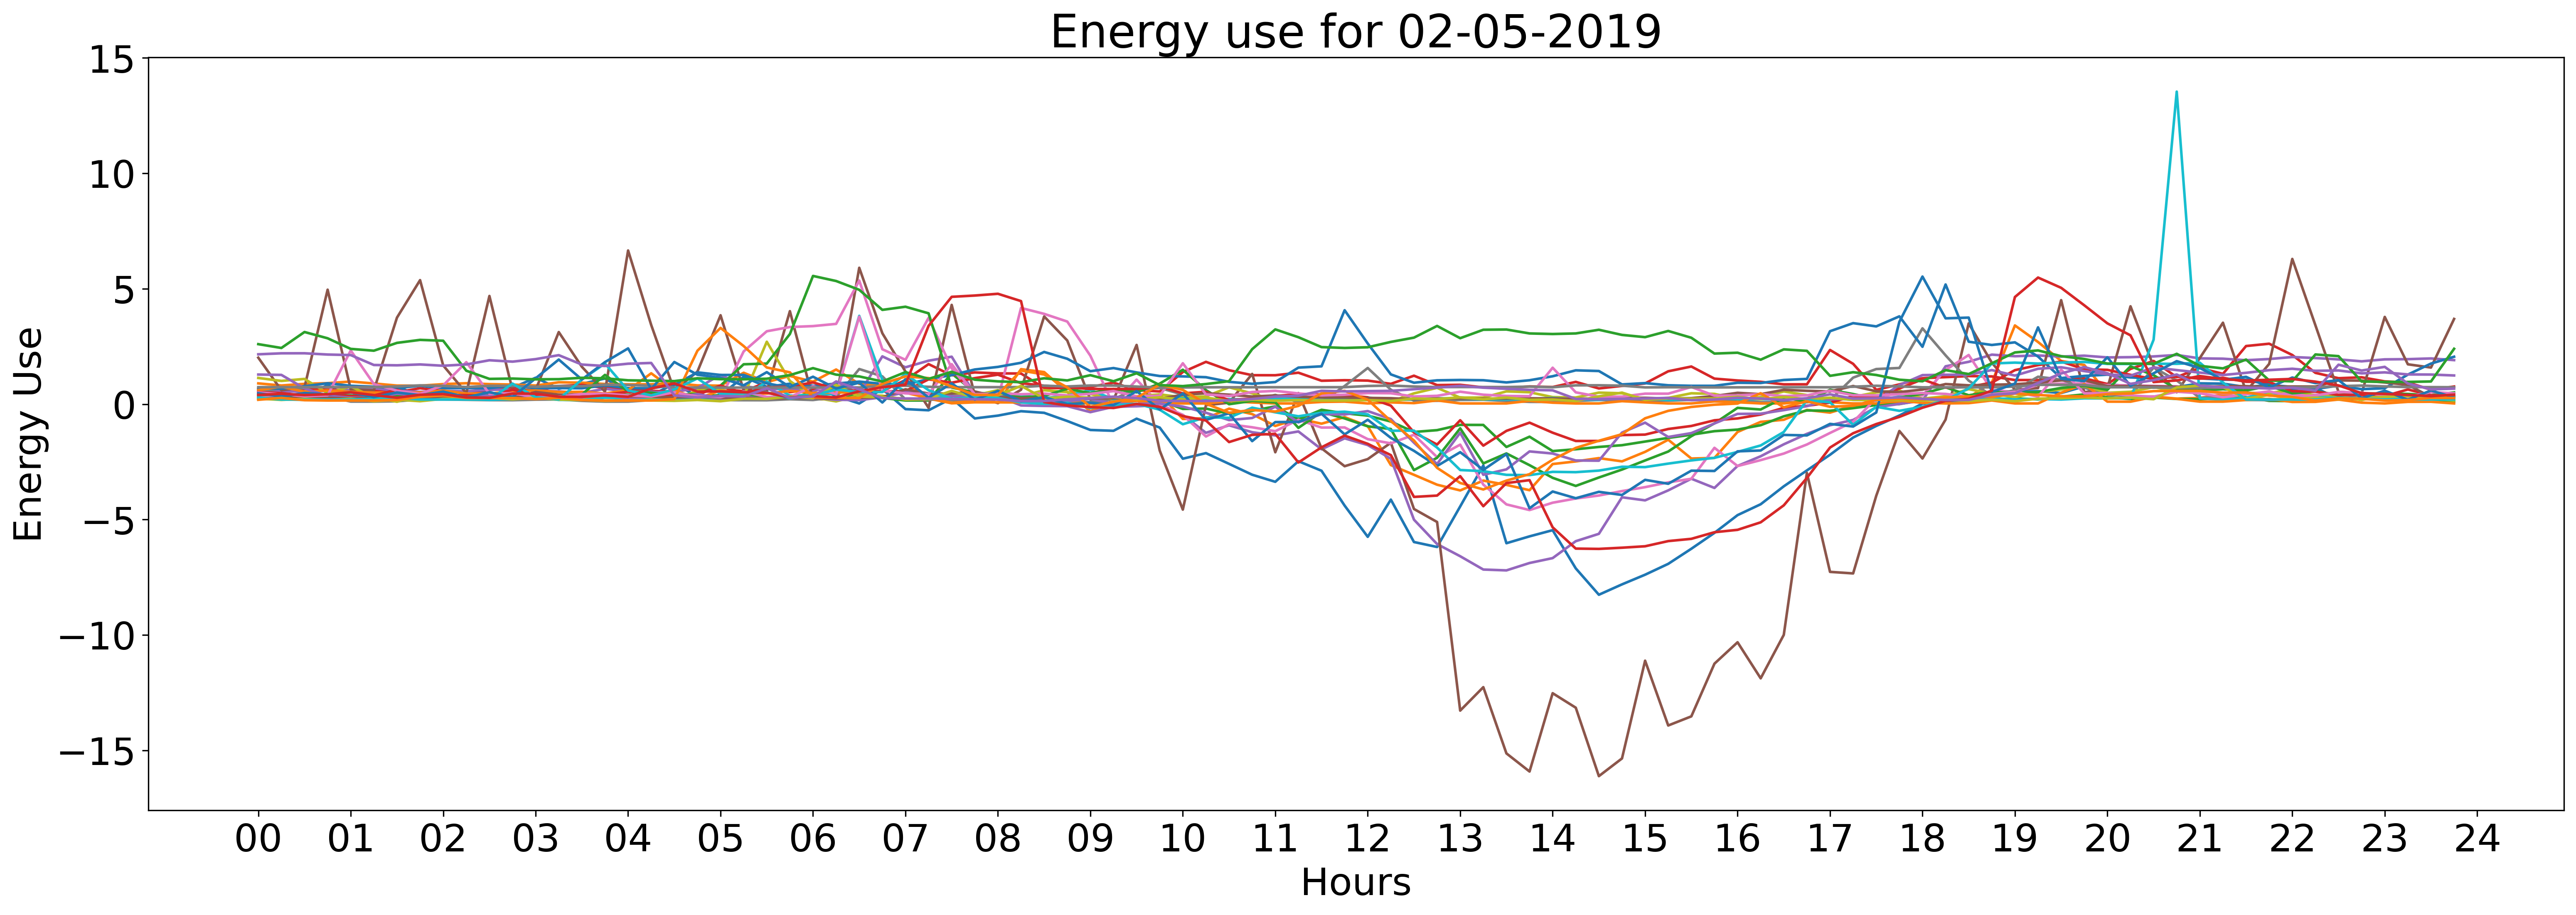

In [24]:
# plt.figure(num=1, figsize=(25, 8), dpi=80, facecolor='w', edgecolor='k', )
day = 20190502
fig = plot_from_multi(multi_ny,day)
fig.savefig(f'{day}_use.png',bbox_inches='tight')
plt.show()

In [25]:
a = [1,2,3,4]
b = ['a','b']
list(itertools.product(a,b))

[(1, 'a'),
 (1, 'b'),
 (2, 'a'),
 (2, 'b'),
 (3, 'a'),
 (3, 'b'),
 (4, 'a'),
 (4, 'b')]

In [26]:
multi_tx.loc[661, 20180101]

0     0.000
1     0.000
2     0.000
3     0.000
4     1.447
      ...  
91    1.456
92    1.264
93    1.025
94    0.654
95    0.873
Name: (661, 20180101), Length: 96, dtype: float64

In [27]:
multi_ny.index.levels[1]

Int64Index([20190501, 20190502, 20190503, 20190504, 20190505, 20190506,
            20190507, 20190508, 20190509, 20190510,
            ...
            20191021, 20191022, 20191023, 20191024, 20191025, 20191026,
            20191027, 20191028, 20191029, 20191030],
           dtype='int64', name='date', length=183)

In [28]:
def make_power_consumption_graph(dataframe):
    ax = plt.gca()
    # gets the total consumption from grid per hour
    def get_total_consumption(df, dateindex):
        consumption = np.zeros(96)
        for i in df.index.levels[0]:
            consumption += df.loc[i, dateindex]
        return consumption
    # creates the histogram array
    def congregate_times(df):
        histogram_of_days = np.zeros(len(df.index.levels[1]))
        index = 0
        for i in df.index.levels[1]:
            histogram_of_days[index] += get_total_consumption(df, i).idxmax()/4
            index += 1
        return histogram_of_days
    # Greates graph
    def pad_hours(string):
        if len(string)<2:
            string = '0'+string
        return string
    
    hours = np.arange(25)
    hours = [pad_hours(str(hour)) for hour in hours]
    
    # Plot energy use data
    max_energy = congregate_times(dataframe)
    plt.hist(max_energy, bins = np.arange(0,24))
    ax.set_xlabel('Hours')
    ax.set_ylabel('Peak draw frequency in a year')
    ax.set_title(f'Max Power Draw') # day-month-year
    fig = plt.gcf()
    
    #plt.show()
    return fig

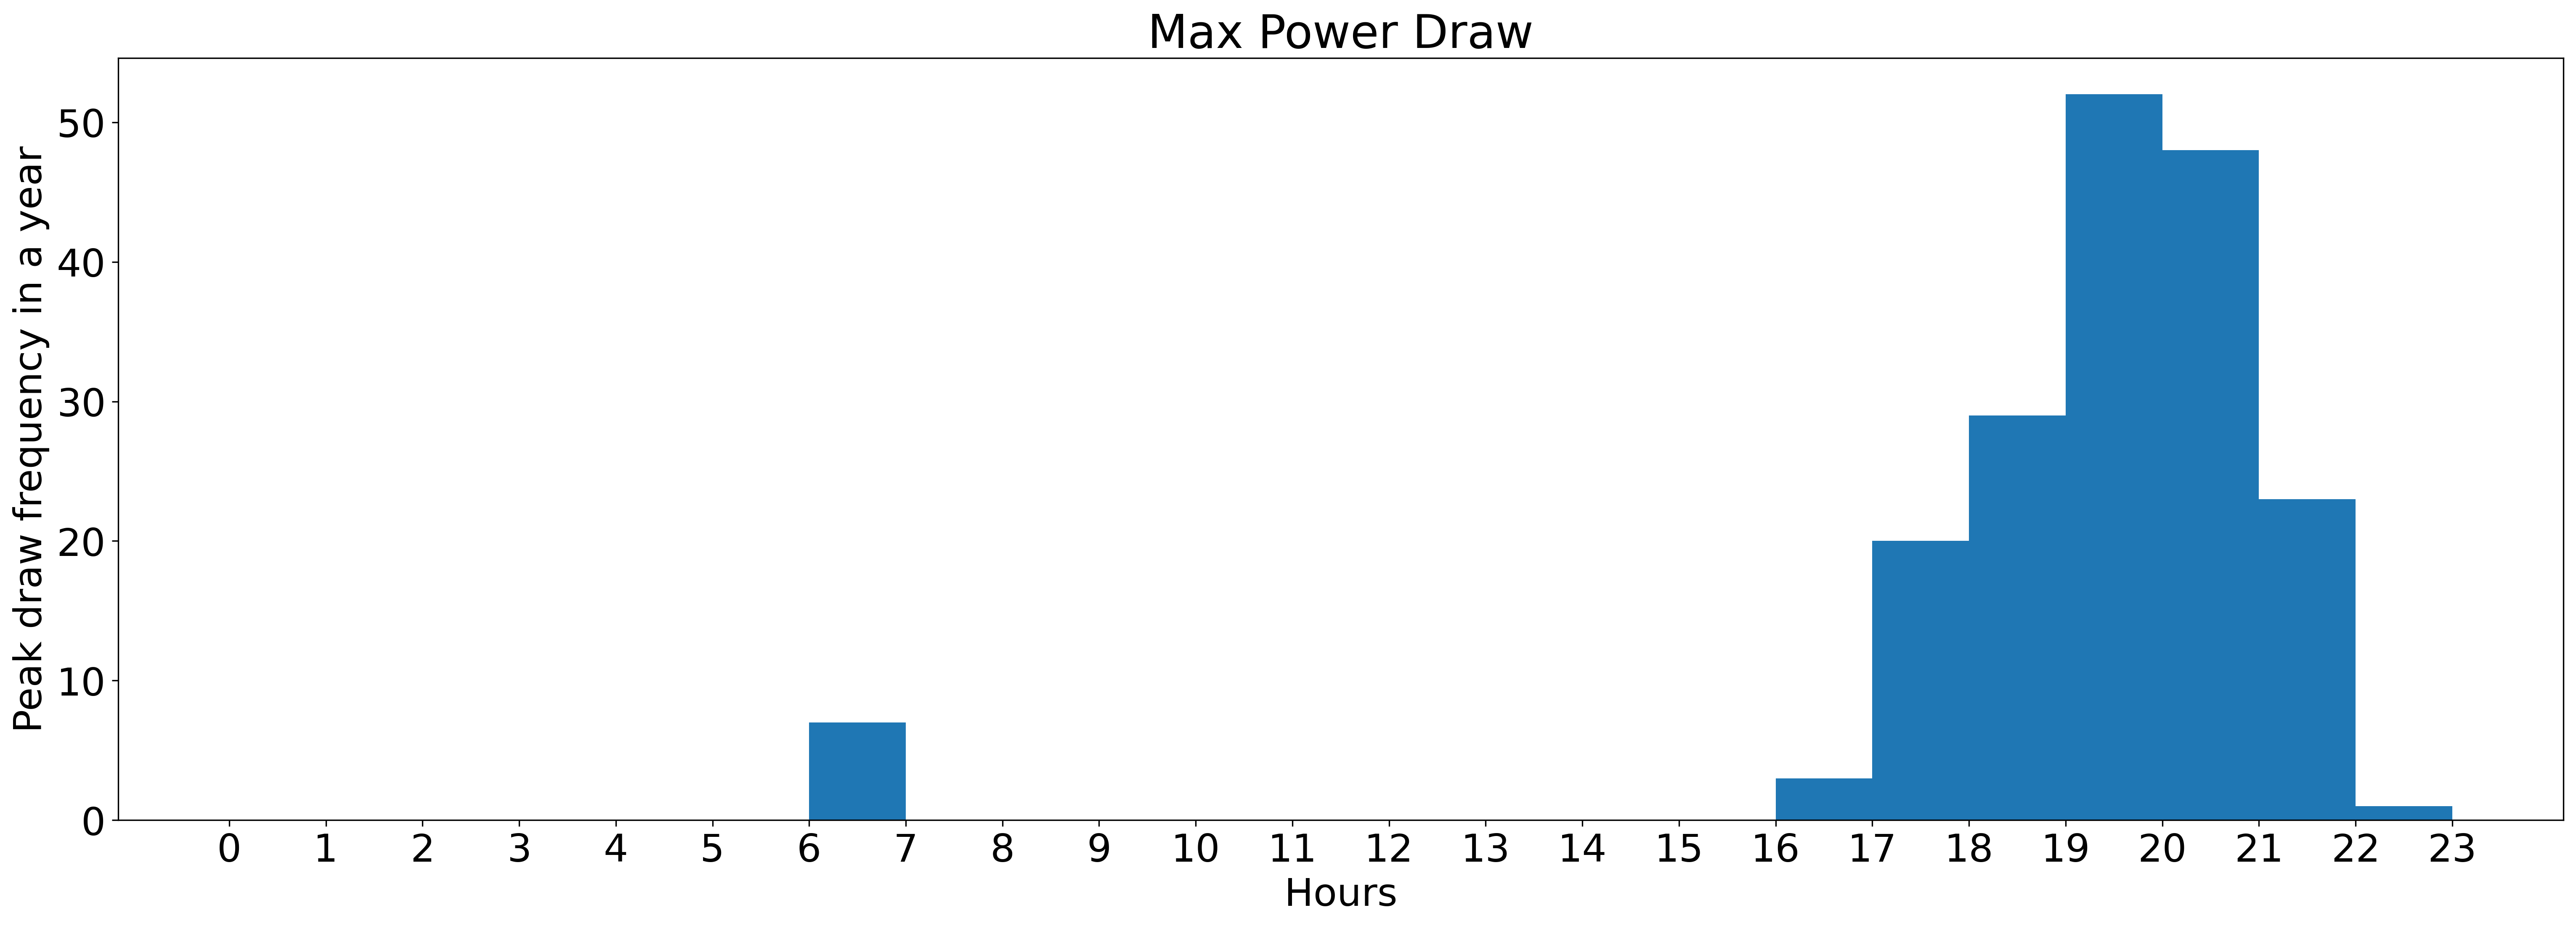

In [31]:
plt.figure(figsize = (25, 8),dpi=300)
plt.rcParams.update({'font.size': 22})
j_idx=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]

plt.xticks(j_idx)
fig1 = make_power_consumption_graph(multi_ny)
fig1.savefig(f'{day}_use.png',bbox_inches='tight')
plt.show()